# <span style="font-family:times; font-size:1.5,em;"> <b> ML_DMFT: A Hybrid Approach to Hubbard Model

<span style="font-family:times; font-size:1.3em;">  Working within the CMT_TRIQS environment, this notebook sets up the necessary Python environment and includes scripts, data handling, and model checkpoints crucial for simulations based on the Dynamical Mean Field Theory (DMFT) applied to the Hubbard model. For a complete setup, additional resources, and saved checkpoints, refer to the GitHub repository: [ML-DMFT Repository](https://github.com/33ron33/ML-DMFT).


## <span style="font-family:times; font-size:1.3em;"> Checking Installed Libraries
<span style="font-family:times; font-size:1.3em;">Before we begin, let's ensure all necessary libraries are installed in our environment. Checking the installed libraries in the environment.

In [1]:
# This command lists all installed Python packages in the current environment.
! pip list 

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiobotocore                   2.7.0
aiohttp                       3.9.0
aioitertools                  0.7.1
aiosignal                     1.2.0
alabaster                     0.7.12
altair                        5.3.0
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
apache-beam                   2.55.1
appdirs                       1.4.4
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array_record                  0.5.1
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.3.4
asttokens                     2.0.5
astunparse                    1.6.3
async-lru

<span style="font-family:times; font-size:1.3em;"> Importing the necessary libraries that would be used in the code-

In [34]:
# Importing libraries from TRIQS for Green's functions 
from triqs.gf import *

# Importing for numerical and graphical operations
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Importing pandas for data manipulation and analysis
import pandas as pd

# Importing plotting interface from TRIQS
from triqs.plot.mpl_interface import oplot, plt

# Importing necessary components from TensorFlow and Keras for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

## <span style="font-family:times; font-size:1.3em;"> Simulation of the Density of States in the Hubbard Model using IPT

<span style="font-family:times; font-size:1.1em;"> This section uses the `IPT` class, which is set up to simulate the Hubbard model under the Iterated Perturbation Theory (IPT) within the Dynamical Mean Field Theory (DMFT) framework. This model uses both Matsubara frequency and imaginary time Green's functions to simulate strong electron correlations.

<span style="font-family:times; font-size:1.1em;"> After defining the `IPT` class and model parameters (like the hopping term `t` and the inverse temperature `beta`), a loop runs over various interaction strengths `U`. For each `U`, the DMFT loop recalculates the self-consistent Green's function in the Matsubara frequency domain. These Green's functions are then analytically continued to real frequencies using the Pade approximation. The resultant density of states (DOS) across these real frequencies is plotted for each `U`, illustrating how the electronic properties vary with interaction strength in strongly correlated electron systems.

<span style="font-family:times; font-size:1.1em;"> The resulting plots show the Density of States against frequency for various values of `U`, providing insights into the spectral properties of the Hubbard model under different interaction regimes.


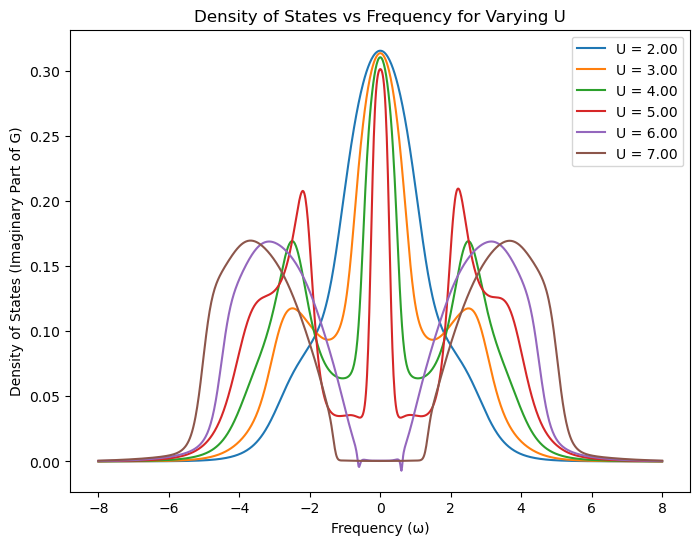

In [10]:
# Definition of the IPT class, which handles IPT calculations within DMFT
class IPT:
    def __init__(self, beta):
        self.beta = beta # Storing the inverse temperature values

         # Initializing the  Matsubara frequency Green's functions
        iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=1001)
        self.G_iw = Gf(mesh=iw_mesh, target_shape=[1, 1])
        self.G0_iw = self.G_iw.copy()
        self.Sigma_iw = self.G_iw.copy()

        # Initializing the  imaginary time Green's functions
        tau_mesh = MeshImTime(beta=beta, S='Fermion', n_tau=10001)
        self.G0_tau = Gf(mesh=tau_mesh, target_shape=[1, 1])
        self.Sigma_tau = self.G0_tau.copy()
    
    # Fourier transform to update the imaginary time self-energy and Green's functions
    def solve(self, U):
        self.G0_tau << Fourier(self.G0_iw)
        self.Sigma_tau << (U**2) * self.G0_tau * self.G0_tau * self.G0_tau
        self.Sigma_iw << Fourier(self.Sigma_tau)

        # Applying the  Dyson's equation to compute the new Green's function in the frequency domain
        self.G_iw << inverse(inverse(self.G0_iw) - self.Sigma_iw)

# Model parameters
t = 1.0  # Hopping term
beta = 20  # Inverse temperature
n_loops = 25  # Number of self-consistency loops

fig, ax = plt.subplots(figsize=(8, 6))

# Looping over different values of U to simulate the system
for U in np.arange(2.0, 7.5, 1.0):
    S = IPT(beta=beta)
    S.G_iw << SemiCircular(2*t) # Initializing the  Green's function with semi-circular DOS

    # Executing the DMFT self-consistency loop
    for i in range(n_loops):
        S.G0_iw << inverse(iOmega_n - t**2 * S.G_iw) # Updating the   non-interacting Green's function for each loop
        S.solve(U) # Executing the IPT solver for the given U

    # Converting to  the real frequencies using Pade approximation
    G_w = GfReFreq(window=(-8.0, 8.0), n_points=1000, target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, n_points=100, freq_offset=0.01)

    # Extracting and plotting the Density of States for each U
    omega = np.linspace(-8, 8, 1000)
    dos = -1/np.pi * G_w.imag.data[:,0,0]
    ax.plot(omega, dos, label=f'U = {U:.2f}')


ax.set_title("Density of States vs Frequency for Varying U")
ax.set_xlabel("Frequency (ω)")
ax.set_ylabel("Density of States (Imaginary Part of G)")
plt.savefig('density_of_states.png', dpi=300)
ax.legend()
plt.show()

## <span style="font-family:times; font-size:1.3em;"> Parallel Computation of Green's Functions for Machine Learning Dataset

<span style="font-family:times; font-size:1.1em;"> Here I am generating the dataset for training a machine learning model to predict Green's functions in the Hubbard model. Here I utilize the `compute_for_U` function to compute the imaginary parts of the first ten Matsubara Green's functions at various interaction strengths `U`. This function initializes and iteratively solves the Hubbard model using the IPT within the DMFT framework for given values of `beta`, `t` (hopping term), and `n_loops` (number of self-consistency loops).

<span style="font-family:times; font-size:1.1em;">  Using the `joblib` library, I have parallelized these computations across multiple cores to efficiently generate a large dataset. The interaction strengths, ranging from 2.0 to 7.5, are finely sampled at 10000 points to capture detailed variations in Green's function behavior with respect to `U`. The results are then formatted into a dictionary, which maps each `U` value to its corresponding Green's function values, preparing the dataset for subsequent machine learning tasks.

In [28]:
# Importing necessary libraries for parallel processing and data handling
from joblib import Parallel, delayed

# Defining a function for computing the Green's functions for a given U using IPT within DMFT
def compute_for_U(U, beta, t, n_loops):
    S = IPT(beta=beta)
    S.G_iw << SemiCircular(2 * t)
    for i in range(n_loops):
        S.G0_iw << inverse(iOmega_n - t**2 * S.G_iw)
        S.solve(U)
    G_values = [S.G_iw[iw][0, 0].imag for iw in list(S.G_iw.mesh)[:10]]
    return (U, G_values)

# Setting up the range of U values to be sampled
U_values = np.linspace(2.0, 7.5, 20000)

# Using the  joblib for parallelizing the computation
results = Parallel(n_jobs=-1)(delayed(compute_for_U)(U, beta, t, n_loops) for U in U_values)

# Converting the results to the format expected by your data analysis code
greens_function_data = {U: G_values for U, G_values in results}

/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## <span style="font-family:times; font-size:1.3em;"> Exporting the Computed Green's Functions to CSV

<span style="font-family:times; font-size:1.1em;"> After calculating the imaginary parts of the Matsubara Green's functions for various interaction strengths `U`, this section structures the data into a Pandas DataFrame for easy manipulation and analysis. Each entry in the DataFrame corresponds to a specific `U`, the value of `beta`, the Matsubara frequency index, and the respective imaginary part of the Green's function at that frequency.

<span style="font-family:times; font-size:1.1em;"> The structured data is then saved to a CSV file, `greens_function.csv`, providing a static, easily accessible dataset that can be utilized in further analyses or machine learning model training. The data is saved without row indices to maintain a clean format.


In [29]:
# Data structure for storing the results
data = {
    "U": [],
    "Beta": [],
    "iw_index": [],
    "G_iw_imag": []
}

# Looping through each U value and corresponding Green's function values to populate the data structure
for U, G_values in greens_function_data.items():
    for index, G_value in enumerate(G_values):
        data["U"].append(U)
        data["Beta"].append(beta)
        data["iw_index"].append(index)
        data["G_iw_imag"].append(G_value)

# Creating a DataFrame from the structured data
df = pd.DataFrame(data)

# Saving the DataFrame to a CSV file
df.to_csv("greens_function_20k.csv", index=False)
print("Data saved to 'greens_function_20k.csv'.")


Data saved to 'greens_function_20k.csv'.


## <span style="font-family:times; font-size:1.3em;">  Loading and Verifying the Green's Functions Dataset

<span style="font-family:times; font-size:1.1em;">  This section demonstrates how to load the previously saved dataset from a CSV file, `greens_function.csv`, into a Pandas DataFrame. This step is crucial for ensuring that the data has been saved and formatted correctly, and it provides an initial peek into the dataset structure through the display of the first few rows.


In [30]:
file_path = 'greens_function_20k.csv'

# Loading the dataset
df = pd.read_csv(file_path, sep=',')

# Displaying the first few rows of the DataFrame to verify!!!
print(df.head())

     U  Beta  iw_index  G_iw_imag
0  2.0    20         0   0.003181
1  2.0    20         1   0.003185
2  2.0    20         2   0.003188
3  2.0    20         3   0.003191
4  2.0    20         4   0.003194


## Data Cleaning and Verification

To ensure the integrity and usability of the dataset for further analysis or machine learning processes, it's crucial to check and clean the data. This section covers several key steps in data cleaning:

1. **Checking Data Types**: It's important to verify that all columns in the dataset have the correct data types. For instance, numerical columns should not be interpreted as strings.

2. **Converting Data Types**: If any columns are found to be of incorrect data types, they are converted to numerical values. The `pd.to_numeric` function is used here, which also handles errors by coercing invalid values to NaN (i.e., it converts errors to missing values).

3. **Checking for Missing Values**: After conversion, the dataset is checked for any missing values that might affect the analysis.

4. **Verifying the Data**: Finally, the first few rows of the dataset are displayed again to ensure that all transformations were applied correctly.

This structured approach to data cleaning helps prepare the dataset for reliable and accurate analysis.


In [31]:
# Check the data types of each column in the DataFrame
print(df.dtypes)

# Convert columns to numerical types where necessary, handling errors by setting invalid parsing as NaN
df['U'] = pd.to_numeric(df['U'], errors='coerce')
df['Beta'] = pd.to_numeric(df['Beta'], errors='coerce')
df['iw_index'] = pd.to_numeric(df['iw_index'], errors='coerce')
df['G_iw_imag'] = pd.to_numeric(df['G_iw_imag'], errors='coerce')

# Check for any missing values in the dataset after type conversion
print(df.isnull().sum())

# Display the first few rows of the DataFrame to confirm the correct data types and check for any obvious issues
print(df.head())


U            float64
Beta           int64
iw_index       int64
G_iw_imag    float64
dtype: object
U            0
Beta         0
iw_index     0
G_iw_imag    0
dtype: int64
     U  Beta  iw_index  G_iw_imag
0  2.0    20         0   0.003181
1  2.0    20         1   0.003185
2  2.0    20         2   0.003188
3  2.0    20         3   0.003191
4  2.0    20         4   0.003194


## Preparing Data for Model Training

Before training a machine learning model, it's essential to split the dataset into training and testing sets. This process helps in evaluating the model's performance on unseen data, ensuring that our model generalizes well rather than merely memorizing the training data.

In this section:
1. **Feature Selection**: We select 'U', 'Beta', and 'iw_index' as features (independent variables) and 'G_iw_imag' as the target variable (dependent variable).
2. **Splitting the Dataset**: We use Scikit-learn's `train_test_split` method to divide the data into a training set and a testing set. The `test_size` parameter is set to 0.2, meaning 20% of the data is reserved for testing.
3. **Verifying Data Split**: After splitting, we print the sizes of the training and testing datasets to ensure the split was successful and to verify the amount of data allocated to each set.

This methodological approach ensures that the data is appropriately prepared for training and evaluating the machine learning model.


In [32]:
from sklearn.model_selection import train_test_split

# Define the features (independent variables) and the target variable (dependent variable)

X = df[['U', 'Beta', 'iw_index']]  # Features that influence the Green's function values

y = df['G_iw_imag']  # Target variable: Imaginary part of the Green's function

# Splitting the dataset into training and testing sets using an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of both training and testing sets to verify the split
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)


Training set size: (160000, 3) (160000,)
Testing set size: (40000, 3) (40000,)


## Model Training and Evaluation for Green's Functions Prediction

This section describes the steps to build, compile, train, and evaluate a neural network that predicts the imaginary part of Green's functions based on interaction strength `U`, inverse temperature `beta`, and Matsubara frequency index. The approach includes:

1. **Model Configuration**: The model architecture is configured with multiple dense layers, including ReLU activations for non-linearity and dropout for regularization to prevent overfitting.

2. **Model Building**: A neural network with a progressive increase in complexity from the input through hidden layers, and then tapering down towards the output layer is constructed. This design helps in capturing complex patterns in the data effectively.

3. **Model Compilation**: The model is compiled with the Adam optimizer and mean squared error as the loss function. Mean absolute error is also tracked as a performance metric to provide insights into the average magnitude of errors in predictions.

4. **Model Training**: The model is trained over 100 epochs with detailed output on training progress. Validation data is used to monitor the model's performance and ensure it generalizes well to new data.

5. **Performance Visualization**: Post-training, plots of training and validation loss, as well as mean absolute error, are generated. These visualizations help in understanding the model's learning curve and ensuring that it is not overfitting or underfitting.

These steps collectively ensure a robust model training process, equipped to handle complex predictive tasks in the field of condensed matter physics.


Epoch 1/50


/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 1.4481e-05 - mean_absolute_error: 6.3542e-04 - val_loss: 1.6221e-09 - val_mean_absolute_error: 3.6733e-05
Epoch 2/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 5.5571e-08 - mean_absolute_error: 1.1657e-04 - val_loss: 6.8233e-09 - val_mean_absolute_error: 7.0831e-05
Epoch 3/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 1.6501e-08 - mean_absolute_error: 7.6086e-05 - val_loss: 9.9513e-10 - val_mean_absolute_error: 2.5092e-05
Epoch 4/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 4.3827e-09 - mean_absolute_error: 3.9035e-05 - val_loss: 4.3776e-10 - val_mean_absolute_error: 1.5837e-05
Epoch 5/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 1.5848e-09 - mean_absolute_error: 2.7714e-05 - val_loss: 3.1473e-09 - val_mean_absolute_error: 5.2475e-05
Epoch 6/50
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 1.3768e-09 - mean_absolute_error: 2.3800e-05 - val_loss: 2.2521e-10 - val_mean_absolute_error: 1.2675e-

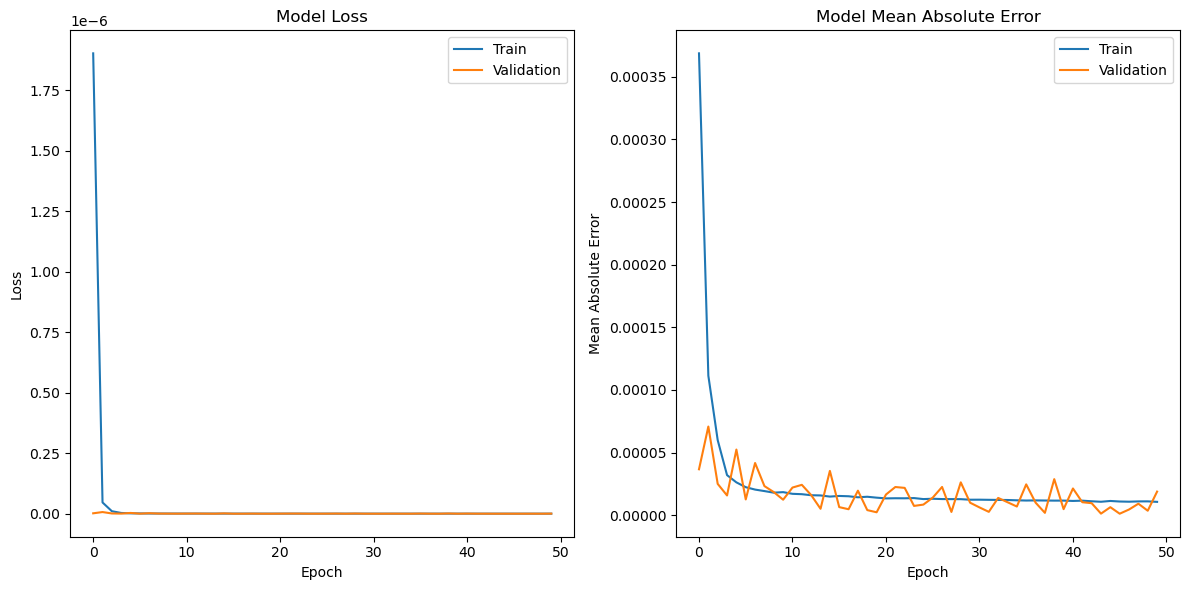

In [45]:
# Model configuration
input_dim = X_train.shape[1]  # Number of features
output_dim = 1  # Output dimension, predicting a single value
learning_rate = 0.0001

# Build the model
model = Sequential([
    Dense(32, input_dim=input_dim, activation='relu'),  # First hidden layer with 64 units and ReLU activation
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(output_dim)  # Output layer
])

# Compile the model with Mean Absolute Error as an additional metric
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mean_absolute_error'])
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=1)

# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("Losses.png", dpi=300)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("Abs.png", dpi=300)

plt.tight_layout()
plt.show()

## Comparing IPT and Machine Learning Predictions of Density of States

This section provides a comparative analysis between traditional Iterated Perturbation Theory (IPT) and machine learning (ML) predictions for the density of states in the Hubbard model. This comparison helps validate the ML model and demonstrates its potential for accelerating computations in condensed matter physics.

1. **IPT Calculations**: We first conduct IPT calculations for varying interaction strengths (U) to compute the density of states using real frequencies derived from the Pade approximation.

2. **ML Predictions**: Next, we use a trained machine learning model to predict the density of states over the same range of interaction strengths. Predictions are made using features like U, beta, and Matsubara frequency indices, which must be appropriately scaled based on the training data distribution.

3. **Visualization**: Both the IPT calculations and ML predictions are plotted for comparison. Two subplots are used: the first displays the IPT results, and the second shows the ML predictions, facilitating a direct visual comparison of both approaches.

4. **Layout Adjustments**: We ensure that the plots are clear and well-labeled, making it easier to analyze the differences and similarities between the traditional and ML-based methods.

This step-by-step breakdown aids in understanding the effectiveness of machine learning models in reproducing and potentially extending the results obtained from conventional theoretical methods.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


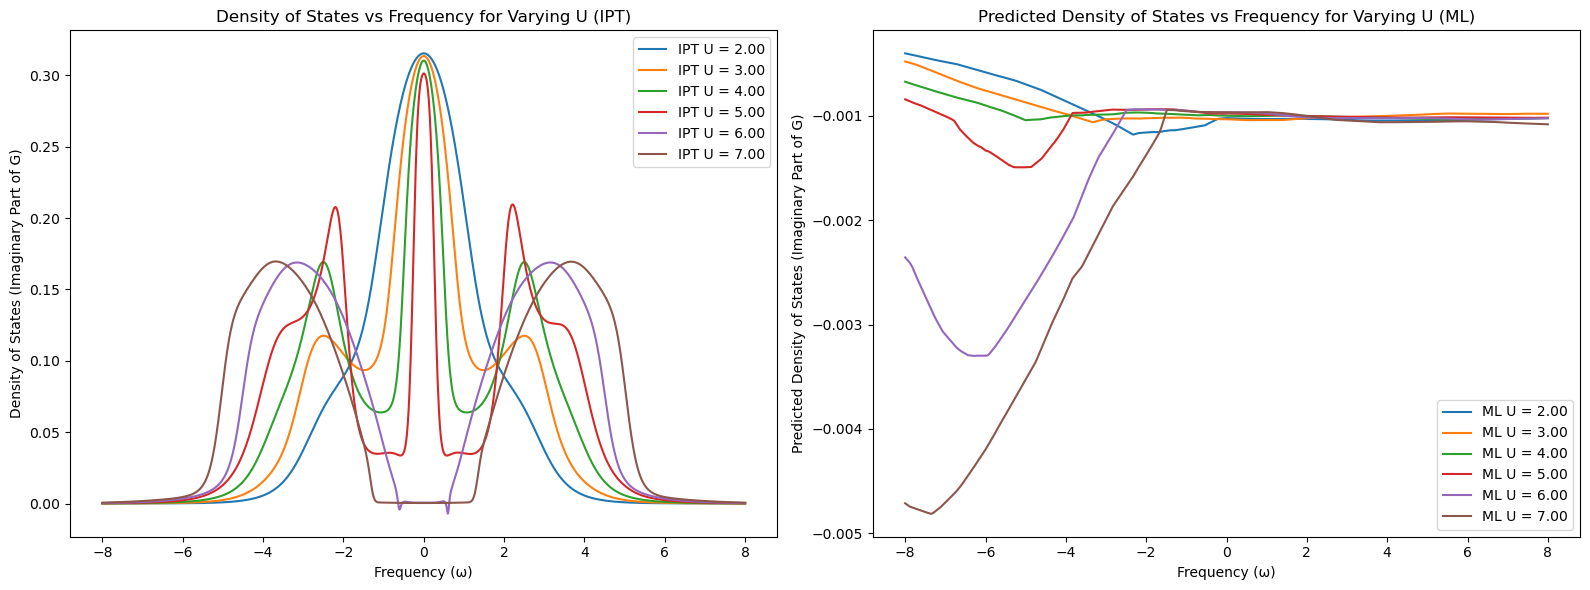

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from triqs.gf import *
from triqs.plot.mpl_interface import oplot, plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Replace with the actual path to your trained model
#model = load_model('greens_function_dataset.csv')

# Parameters of the model
t = 1.0
beta = 20
n_loops = 25

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot - IPT calculations
for U in np.arange(2.0, 7.5, 1.0):
    S = IPT(beta=beta)
    S.G_iw << SemiCircular(2*t)

    # DMFT loop
    for i in range(n_loops):
        S.G0_iw << inverse(iOmega_n - t**2 * S.G_iw)
        S.solve(U)

    # Convert to real frequencies using Pade approximation
    G_w = GfReFreq(window=(-8.0, 8.0), n_points=1000, target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, n_points=100, freq_offset=0.01)

    # Plot IPT results
    omega = np.linspace(-8, 8, 1000)
    dos = -1/np.pi * G_w.imag.data[:,0,0]
    ax1.plot(omega, dos, label=f'IPT U = {U:.2f}')

# Second subplot - ML predictions
for U in np.arange(2.0, 7.5, 1.0):
    # Generate the frequency range for the predictions
    omega = np.linspace(-8.0, 8.0, 1000)
    # Create an array of the input parameters for the ML model
    X_pred = np.array([[U, beta, iw_value] for iw_value in omega])
    
    # If your model expects scaled data, you must scale X_pred accordingly
    scaler = MinMaxScaler()
    scaler.fit(df[['U', 'Beta', 'iw_index']])  # Use the correct column name 'iw'
    X_pred_scaled = scaler.transform(X_pred)

    # Make predictions
    y_pred = model.predict(X_pred_scaled)

    # Plot ML predictions
    dos_pred = -1/np.pi * y_pred.flatten()
    ax2.plot(omega, dos_pred, label=f'ML U = {U:.2f}')

# Set titles and labels for IPT plot
ax1.set_title("Density of States vs Frequency for Varying U (IPT)")
ax1.set_xlabel("Frequency (ω)")
ax1.set_ylabel("Density of States (Imaginary Part of G)")
ax1.legend()

# Set titles and labels for ML predictions plot
ax2.set_title("Predicted Density of States vs Frequency for Varying U (ML)")
ax2.set_xlabel("Frequency (ω)")
ax2.set_ylabel("Predicted Density of States (Imaginary Part of G)")
ax2.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("Density_of_States_Comparison_9.png", dpi=300)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


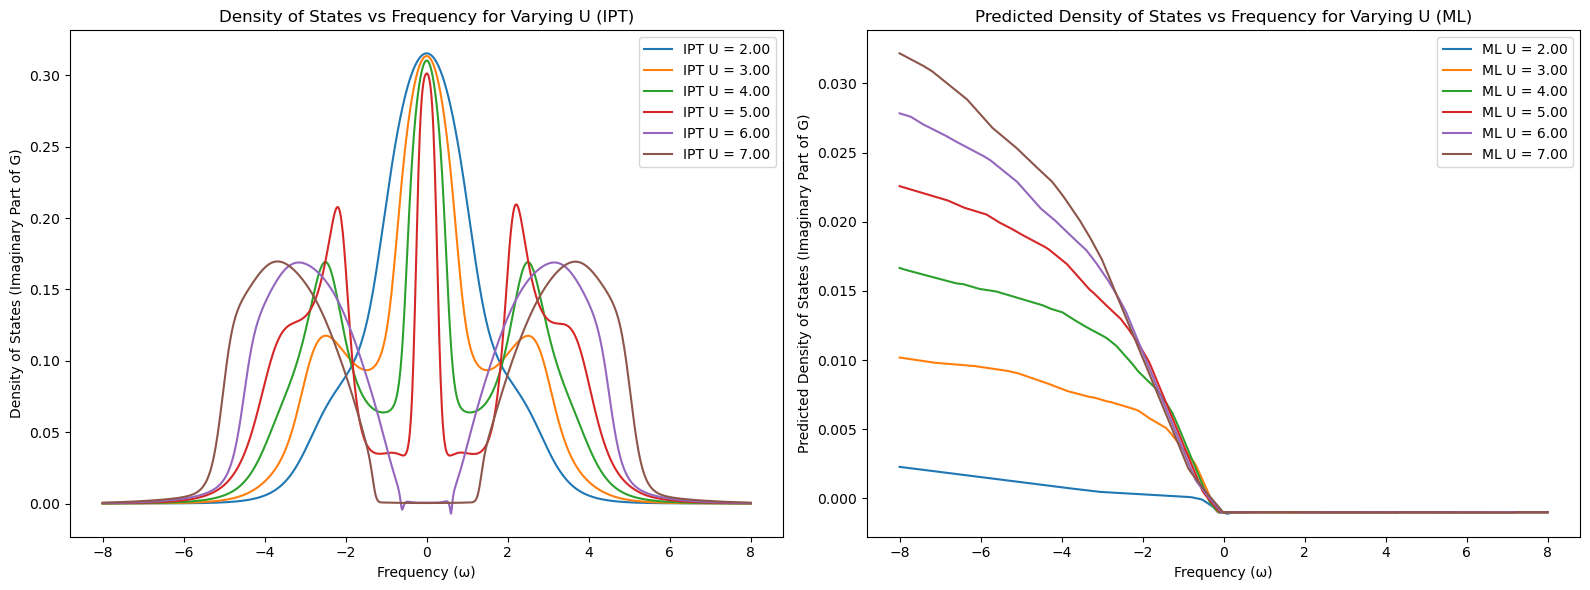

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from triqs.gf import *
from triqs.plot.mpl_interface import oplot, plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Replace with the actual path to your trained model
model = load_model('trained_model.h5')


# Parameters of the model
t = 1.0
beta = 20
n_loops = 25

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot - IPT calculations
for U in np.arange(2.0, 7.5, 1.0):
    S = IPT(beta=beta)
    S.G_iw << SemiCircular(2*t)

    # DMFT loop
    for i in range(n_loops):
        S.G0_iw << inverse(iOmega_n - t**2 * S.G_iw)
        S.solve(U)

    # Convert to real frequencies using Pade approximation
    G_w = GfReFreq(window=(-8.0, 8.0), n_points=1000, target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, n_points=100, freq_offset=0.01)

    # Plot IPT results
    omega = np.linspace(-8, 8, 1000)
    dos = -1/np.pi * G_w.imag.data[:,0,0]
    ax1.plot(omega, dos, label=f'IPT U = {U:.2f}')
# Assuming 'scaler' and 'model' are loaded correctly as described above
omega = np.linspace(-8.0, 8.0, 1000)  # Consistent with training

for U in np.arange(2.0, 7.5, 1.0):
    X_pred = np.array([[U, beta, w] for w in omega])
    X_pred_scaled = scaler.transform(X_pred)  # Use pre-fitted scaler
    y_pred = model.predict(X_pred_scaled)
    dos_pred = -1/np.pi * y_pred.flatten()
    ax2.plot(omega, dos_pred, label=f'ML U = {U:.2f}')


# Set titles and labels for IPT plot
ax1.set_title("Density of States vs Frequency for Varying U (IPT)")
ax1.set_xlabel("Frequency (ω)")
ax1.set_ylabel("Density of States (Imaginary Part of G)")
ax1.legend()

ax2.set_title("Predicted Density of States vs Frequency for Varying U (ML)")
ax2.set_xlabel("Frequency (ω)")
ax2.set_ylabel("Predicted Density of States (Imaginary Part of G)")
ax2.legend()


# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("Density_of_States_Comparison_10.png", dpi=1200)
plt.show()

/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/nfs/home/rnain/.conda/envs/TRIQS/lib/python3.12/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


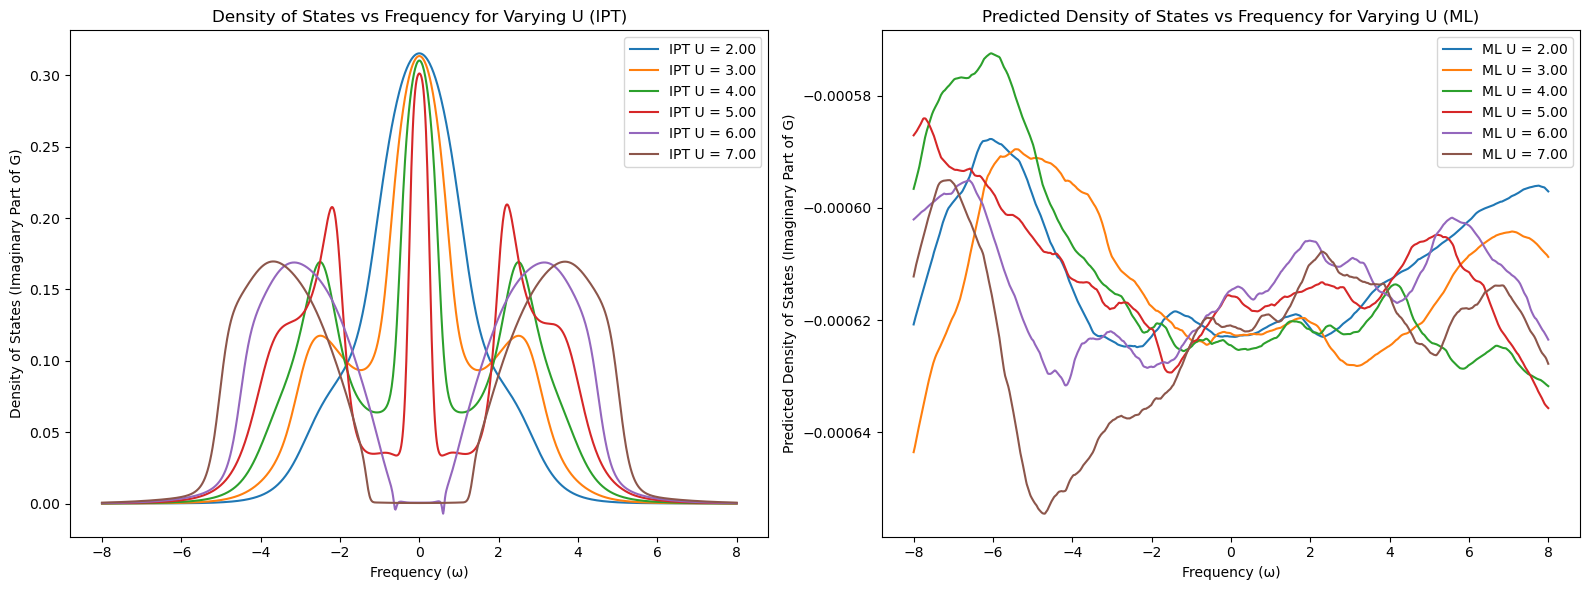

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from triqs.gf import *
from triqs.plot.mpl_interface import oplot, plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load the pre-trained model (ensure you replace with the actual path to your model)
#model = load_model('path_to_trained_model.h5')

# Model parameters
t = 1.0
beta = 20
n_loops = 25

# Set up the figure for plotting IPT results and ML predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot - IPT calculations for various U values
for U in np.arange(2.0, 7.5, 1.0):
    S = IPT(beta=beta)
    S.G_iw << SemiCircular(2*t)

    # DMFT loop to find self-consistent solutions
    for i in range(n_loops):
        S.G0_iw << inverse(iOmega_n - t**2 * S.G_iw)
        S.solve(U)

    # Convert Matsubara frequencies to real frequencies using Pade approximation
    G_w = GfReFreq(window=(-8.0, 8.0), n_points=1000, target_shape=[1,1])
    G_w.set_from_pade(S.G_iw, n_points=100, freq_offset=0.01)

    # Plot the IPT results for the density of states
    omega = np.linspace(-8, 8, 1000)
    dos = -1/np.pi * G_w.imag.data[:,0,0]
    ax1.plot(omega, dos, label=f'IPT U = {U:.2f}')

# Second subplot - ML predictions for varying U values
for U in np.arange(2.0, 7.5, 1.0):
    # Generate input features for ML predictions over the frequency range
    omega = np.linspace(-8.0, 8.0, 1000)
    X_pred = np.array([[U, beta, iw_value] for iw_value in omega])

    # Scale the input features based on training data scaling
    scaler = MinMaxScaler()
    scaler.fit(df[['U', 'Beta', 'iw_index']])  # Ensure this matches the feature scaling during training
    X_pred_scaled = scaler.transform(X_pred)

    # Make predictions using the ML model
    y_pred = model.predict(X_pred_scaled)

    # Plot the ML predictions for the density of states
    dos_pred = -1/np.pi * y_pred.flatten()
    ax2.plot(omega, dos_pred, label=f'ML U = {U:.2f}')

# Set titles and labels for IPT and ML prediction plots
ax1.set_title("Density of States vs Frequency for Varying U (IPT)")
ax1.set_xlabel("Frequency (ω)")
ax1.set_ylabel("Density of States (Imaginary Part of G)")
ax1.legend()

ax2.set_title("Predicted Density of States vs Frequency for Varying U (ML)")
ax2.set_xlabel("Frequency (ω)")
ax2.set_ylabel("Predicted Density of States (Imaginary Part of G)")
ax2.legend()

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("Density_of_States_Comparison_11.png", dpi=300)
plt.show()
